# Классификация музыкальных произведений по жанрам

Цель исследования: правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. В распоряжении имеется датасет, в котором собраны некоторые данные, содержащие характеристики музыкальных произведений и их жанры. 

Данные находятся в файле /master1/kaggle_music_genre_train.csv и содержат следующие <b>признаки</b>:
- `instance_id` - уникальный идентификатор трека;
- `track_name` - название трека;
- `acousticness` - акустичность;
- `danceability` - танцевальность;
- `duration_ms` -продолжительность в милисекундах;
- `energy` - энергичность;
- `instrumentalness` - инструментальность;
- `key` - базовый ключ (нота) произведения;
- `liveness` - привлекательность;
- `loudness` - громкость;
- `mode` - указывает на модальность (мажорную или минорную) трека;
- `speechiness` - выразительность;
- `tempo` - темп;
- `obtained_date` - дата загрузки в сервис;
- `valence` - привлекательность произведения для пользователей сервиса;
- `music_genre` - музыкальный жанр.

Данные для которых надо предсказать жанр для каждого трека находятся в файле /master1/kaggle_music_genre_test.csv

Примечания:
- Для оценки качества моделей необходимо применить метрику F1(micro).

Импорт необходимых библиотек:

In [1]:
import matplotlib.pyplot as plt
import nltk

import numpy as np
import optuna
import pandas as pd
import phik
import re
import seaborn as sns

from catboost import CatBoostClassifier, Pool

from lightgbm import LGBMClassifier

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [2]:
!pip install langdetect
from langdetect import detect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=4c6f43e3dbfb579ecd7f4d83e91c02c7673b626f4e5db6a0eb58231360f7b793
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


## 1. Подготовка данных

### 1.1. Загрузка данных и вывод основной информации

Чтение csv-файла и сохранение в переменную data_train и data_test:

In [3]:
data_train = pd.read_csv('../input/music-genre-prediction-m124ds/kaggle_music_genre_train.csv')
data_test = pd.read_csv('../input/music-genre-prediction-m124ds/kaggle_music_genre_test.csv')

In [4]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print(f'Вывод первых {size} строк датафрейма:')
    pd.set_option('display.max_columns', 30)
    display(data.head(size))
    print('\nВывод основной информации о датафрейме:')
    data.info()
    print('\nКоличество пропусков в датафрейме:')
    print(pd.DataFrame(np.array([data.isna().sum(), data.isna().mean()*100]).T, 
                                columns=['количество пропусков', 'доля пропусков, %'], index=data.columns))
    print(f'\nСуммарное количество пропусков в датафрейме: {data.isna().sum().sum()}, '
          + f'доля пропусков: {round(data.isna().mean().sum()*100, 2)} %')
    display(data.describe())
    print('\n')
    for categ in data.columns[data.dtypes == 'object']:
        print(f'Уникальные значения столбца {categ}: {(data[categ].unique())}\n')

Вывод основной информации о датафрейме data_train:

In [5]:
about_df(data_train)

Вывод первых 5 строк датафрейма:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtyp

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000




Уникальные значения столбца track_name: ['Highwayman' 'Toes Across The Floor' 'First Person on Earth' ...
 'Original Prankster' '4Peat' 'Trouble (feat. MC Spyder)']

Уникальные значения столбца key: ['D' 'A' 'E' 'G#' 'C' 'D#' 'A#' 'F' 'F#' nan 'G' 'C#' 'B']

Уникальные значения столбца mode: ['Major' 'Minor' nan]

Уникальные значения столбца obtained_date: ['4-Apr' '3-Apr' '5-Apr' '1-Apr']

Уникальные значения столбца music_genre: ['Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']



In [6]:
about_df(data_test)

Вывод первых 5 строк датафрейма:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000




Уникальные значения столбца track_name: ['Low Class Conspiracy' 'The Hunter' 'Hate Me Now' ... 'Bipolar'
 'Dead - NGHTMRE Remix'
 'A Night In Tunisia - Remastered 1998 / Rudy Van Gelder Edition']

Уникальные значения столбца key: ['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']

Уникальные значения столбца mode: ['Minor' 'Major' nan]

Уникальные значения столбца obtained_date: ['4-Apr' '3-Apr' '5-Apr' '1-Apr']



<b>Вывод:</b>
- значения в столбце key соответствуют 7 нотам;

### 1.2. Предобработка данных

#### 1.2.1. Обработка пропущенных значений

In [7]:
#data_train = data_train.dropna(subset=['key', 'mode', 'tempo']).reset_index(drop=True)
data_train.loc[data_train['key'].isna(), 'key'] = data_train['key'].mode()[0]
data_train.loc[data_train['mode'].isna(), 'mode'] = data_train['mode'].mode()[0]
data_train.loc[data_train['tempo'].isna(), 'tempo'] = data_train['tempo'].median()

In [8]:
data_test.loc[data_test['key'].isna(), 'key'] = data_test['key'].mode()[0]
data_test.loc[data_test['mode'].isna(), 'mode'] = data_test['mode'].mode()[0]
data_test.loc[data_test['tempo'].isna(), 'tempo'] = data_test['tempo'].median()

In [9]:
#data_train.info()

In [10]:
#data_test.info()

#### 1.2.2. Обработка дубликатов

Поиск явных дубликатов в датафрейме data_train:

In [11]:
data_train.duplicated().sum()

0

Поиск неявных дубликатов в датафрейме data_train:

In [12]:
data_train[data_train[['track_name', 'duration_ms']].duplicated(keep=False)].sort_values(by='track_name')

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
7581,77103.0,'75 aka Stay With You,0.030700,0.712,371507.0,0.8270,0.795,C#,0.122,-7.331,Major,0.0414,126.001,4-Apr,0.3050,Jazz
17628,71962.0,'75 aka Stay With You,0.030700,0.712,371507.0,0.8270,0.795,C#,0.122,-7.331,Major,0.0414,126.001,4-Apr,0.3050,Electronic
15701,20145.0,(Your Love Keeps Lifting Me) Higher & Higher,0.176000,0.631,181067.0,0.6900,0.000,D,0.121,-6.676,Major,0.0531,94.574,4-Apr,0.9380,Blues
11638,60181.0,(Your Love Keeps Lifting Me) Higher & Higher,0.176000,0.631,181067.0,0.6900,0.000,D,0.121,-6.676,Major,0.0531,94.574,4-Apr,0.9380,Rock
20381,43672.0,1 on 1,0.000525,0.905,192840.0,0.6770,0.000,D,0.251,-7.987,Major,0.3450,140.882,4-Apr,0.5980,Rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,49315.0,wokeuplikethis*,0.013800,0.785,235535.0,0.6200,0.000,G#,0.150,-6.668,Major,0.2540,78.476,4-Apr,0.4780,Hip-Hop
20375,27588.0,アシタカとサン - Piano Solo Feature,0.975000,0.338,273400.0,0.1260,0.911,C#,0.107,-14.419,Major,0.0284,79.882,4-Apr,0.0648,Classical
993,38507.0,アシタカとサン - Piano Solo Feature,0.975000,0.338,273400.0,0.1260,0.911,C#,0.107,-14.419,Major,0.0284,79.882,4-Apr,0.0648,Anime
10093,24851.0,花水木の咲く頃 - 辻井伸行,0.994000,0.270,209600.0,0.0171,0.921,E,0.145,-31.429,Major,0.0410,70.931,4-Apr,0.1470,Classical


Удаление неявных дубликатов в датафрейме data_train:

In [13]:
data_train = data_train.drop_duplicates(subset=['track_name', 'duration_ms'], keep='first').reset_index(drop=True)

#### 1.2.3. Удаление неинформативных признаков

Создадим копии датафреймов и удалим неинформативные признаки, такие как уникальный номер трека и его название:

In [14]:
data_train_copy = data_train.copy()
data_test_copy = data_test.copy()

In [15]:
data_train = data_train.drop(['instance_id'], axis=1)
data_test = data_test.drop(['instance_id'], axis=1)

#### 1.2.4. Обработка аномальных значений

- <b>акустичность (acousticness)</b>

Построим гистограмму для признака acousticness датафрейма data_train:

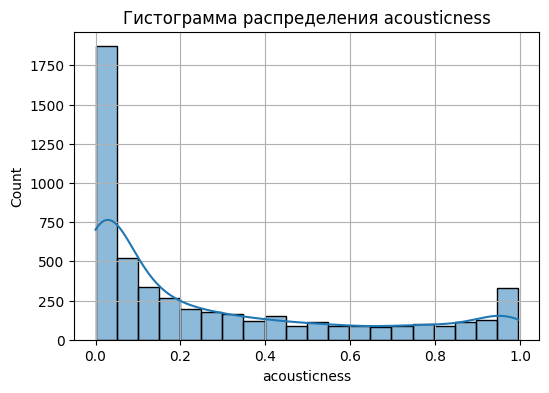

In [16]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['acousticness'], kde=True)
w.set(title=f'Гистограмма распределения acousticness')
plt.show()

Для признака acousticness аномальных значений не обнаружено.

- <b>танцевальность (danceability)</b>

Построим гистограмму для признака danceability датафрейма data_train:

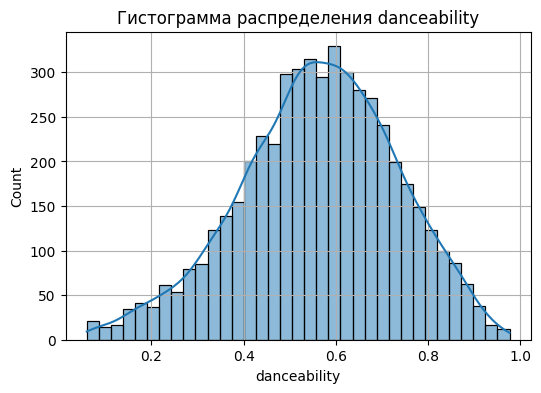

In [17]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['danceability'], kde=True)
w.set(title=f'Гистограмма распределения danceability')
plt.show()

- <b>продолжительность в милисекундах (duration_ms)</b>

Построим гистограмму для признака duration_ms датафрейма data_train:

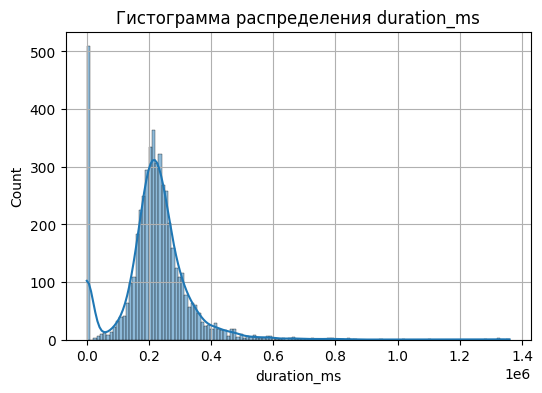

In [18]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['duration_ms'], kde=True)
w.set(title=f'Гистограмма распределения duration_ms')
plt.show()

Из характеристик, построенных в 1.1, и гистограммы были обнаружены значения duration_ms <= 0. Выведем их:

In [19]:
data_train.query('duration_ms <= 0')

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
13,Iwanakutemo Tsutawaru Arewa Sukoshi Usoda - Al...,0.11000,0.470,-1.0,0.6410,0.000000,F#,0.1550,-7.454,Major,0.0658,86.387,4-Apr,0.6380,Anime
26,"Serenade in B flat, K.361 ""Gran partita"": 3. A...",0.99100,0.154,-1.0,0.0384,0.902000,G,0.1090,-26.909,Major,0.0405,68.199,4-Apr,0.0393,Classical
35,Flodgin,0.08480,0.748,-1.0,0.7120,0.000000,D,0.1320,-5.651,Major,0.1430,140.055,4-Apr,0.1800,Rap
50,Things My Father Said,0.05400,0.482,-1.0,0.6270,0.000003,D,0.1110,-5.779,Major,0.0300,95.903,4-Apr,0.1700,Alternative
55,"Fidelio, Op. 72, Act I: Ha! Welch ein Augenbli...",0.90900,0.374,-1.0,0.2270,0.000069,A#,0.6860,-18.719,Major,0.0579,78.236,4-Apr,0.2640,Classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19782,Airborne - MUST DIE! Remix,0.00298,0.450,-1.0,0.9150,0.446000,F,0.7710,-1.404,Minor,0.2360,137.948,4-Apr,0.1560,Electronic
19786,"Idomeneo, TrV 262, Act I (After W.A. Mozart): ...",0.98200,0.372,-1.0,0.1590,0.000001,G,0.1650,-21.129,Major,0.0364,135.617,3-Apr,0.5120,Classical
19787,I Want My Milk (I Want it Now),0.96600,0.638,-1.0,0.0689,0.000001,E,0.1020,-16.222,Major,0.0659,120.160,3-Apr,0.6950,Blues
19795,理性と力,0.62700,0.461,-1.0,0.4360,0.892000,G,0.1330,-9.381,Major,0.0301,130.035,4-Apr,0.2640,Anime


Заполним значения duration_ms<=0 медианным значением:

In [20]:
data_train.loc[data_train['duration_ms'] <= 0, 'duration_ms'] = data_train['duration_ms'].median()

Аналогичным образом поступим для датафрейма data_test:

In [21]:
data_test.loc[data_test['duration_ms'] <= 0, 'duration_ms'] = data_test['duration_ms'].median()

- <b>энергичность (energy)</b>

Построим гистограмму для признака energy датафрейма data_train:

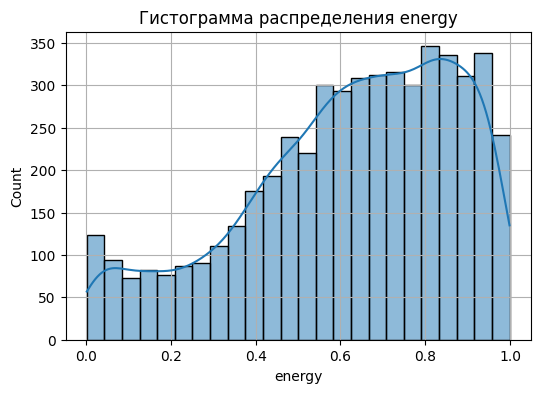

In [22]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['energy'], kde=True)
w.set(title=f'Гистограмма распределения energy')
plt.show()

Для признака energy аномальных значений не обнаружено.

- <b>инструментальность (instrumentalness)</b>

Построим гистограмму для признака instrumentalness датафрейма data_train:

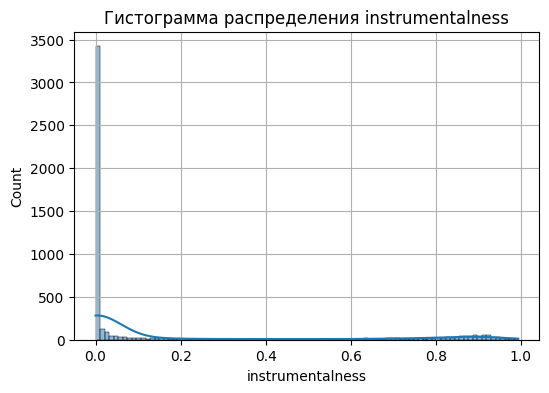

In [23]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['instrumentalness'], kde=True)
w.set(title=f'Гистограмма распределения instrumentalness')
plt.show()

Для признака instrumentalness аномальных значений не обнаружено.

- <b>привлекательность (liveness)</b>

Построим гистограмму для признака liveness датафрейма data_train:

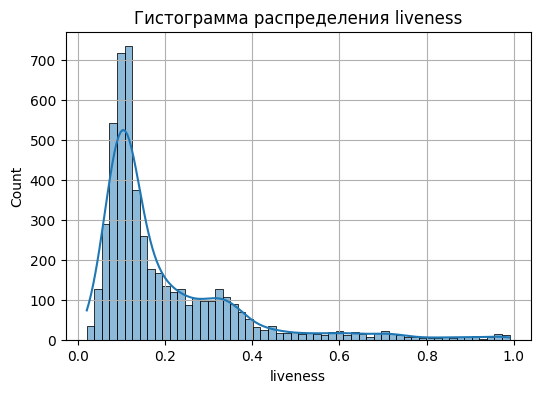

In [24]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['liveness'], kde=True)
w.set(title=f'Гистограмма распределения liveness')
plt.show()

Для признака liveness аномальных значений не обнаружено.

- <b>громкость (loudness)</b>

Построим гистограмму для признака loudness датафрейма data_train:

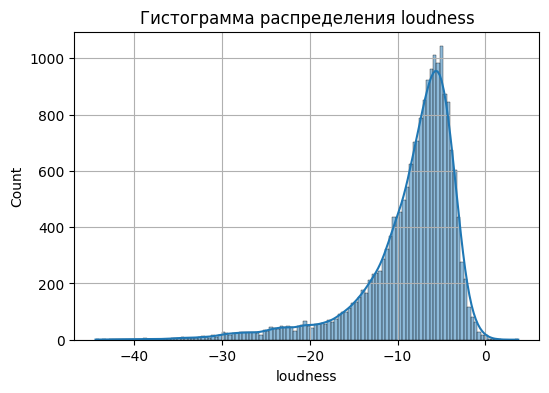

In [25]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_train['loudness'], kde=True)
w.set(title=f'Гистограмма распределения loudness')
plt.show()

In [26]:
#data_train['loudness'] = data_train['loudness'].abs()
#data_train['loudness'] = data_train['loudness'].abs()

In [27]:
data_train.loc[data_train['loudness'] >= 0, 'loudness'] = data_train['loudness'].median()

In [28]:
data_train['loudness'].median()

-7.077000000000001

In [29]:
data_test.loc[data_test['loudness'] >= 0, 'loudness'] = data_test['loudness'].median()

- <b>выразительность (speechiness)</b>

Построим гистограмму для признака speechiness датафрейма data_train:

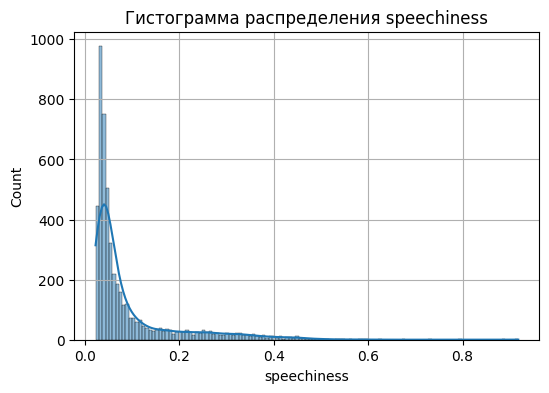

In [30]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['speechiness'], kde=True)
w.set(title=f'Гистограмма распределения speechiness')
plt.show()

Для признака liveness аномальных значений не обнаружено.

- <b>темп (tempo)</b>

Построим гистограмму для признака tempo датафрейма data_train:

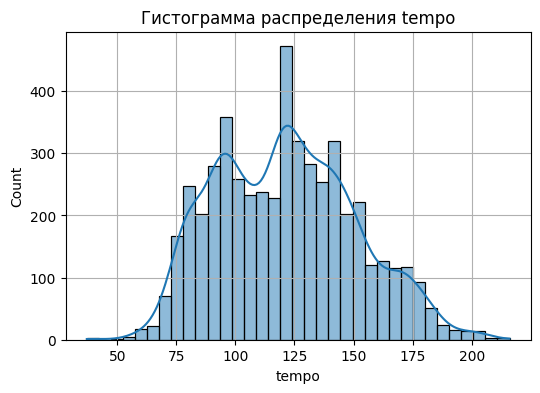

In [31]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['tempo'], kde=True)
w.set(title=f'Гистограмма распределения tempo')
plt.show()

Из внешних источников найдено, что самый медленный темп - Grave около 40 ударов/мин, самый быстрый  Prestissimo около 208 ударов/мин, что приблизительно равно min и max значениям признака, найденный для признака в п. 1.1.<br>
Для признака tempo аномальных значений не обнаружено.

- <b>привлекательность произведения для пользователей сервиса (valence)</b>

Построим гистограмму для признака valence датафрейма data_train:

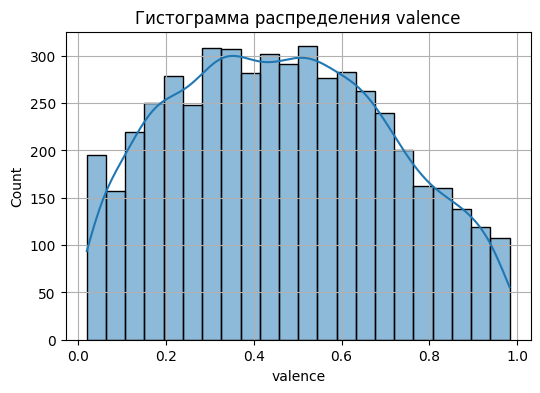

In [32]:
plt.figure(figsize=(6,4))
plt.grid()
w = sns.histplot(data=data_test['valence'], kde=True)
w.set(title=f'Гистограмма распределения valence')
plt.show()

Для признака valence аномальных значений не обнаружено.

#### Создание нового признака

In [33]:
col = len(data_train.columns) - 1

list_words = ['serenade', 'symphony', 'sonata', 'remix', 'op', 'concerto',\
              'prelude', 'de', 'no.', 'feat', 'mix', 'minor', 'major', 'blues',\
              'allegro', 'adagio', 'act']
# убрала 'digital', 'ballet', 'mc', 'sex', '(mono', 'radio', track' '&' 'edit', '*', 
for word in list_words:
    data_train.insert (loc = col , column=word, value=0)
    col +=1
    
data_train

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,serenade,...,remix,op,concerto,prelude,de,no.,feat,mix,minor,major,blues,allegro,adagio,act,music_genre
0,Highwayman,0.48000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Country
1,Toes Across The Floor,0.24300,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
2,First Person on Earth,0.22800,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
3,No Te Veo - Digital Single,0.05580,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Hip-Hop
4,Chasing Shadows,0.22700,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19814,O Pato,0.71900,0.725,219427.0,0.483,0.000000,G,0.0797,-13.314,Minor,0.0438,87.413,4-Apr,0.942,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Jazz
19815,Mt. Washington,0.19000,0.482,198933.0,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4-Apr,0.174,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
19816,Original Prankster,0.00061,0.663,220947.0,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4-Apr,0.942,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
19817,4Peat,0.00310,0.914,162214.0,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4-Apr,0.215,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rap


In [34]:
for i in range(data_train.shape[0]-1):
    data_train.loc[i, 'track_name'] = data_train.loc[i, 'track_name'].lower()
    for word in list_words:
        if data_train.loc[i, 'track_name'].find(word) != -1:
            data_train.loc[i, word] = 1

In [35]:
data_train.head(10)

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,serenade,...,remix,op,concerto,prelude,de,no.,feat,mix,minor,major,blues,allegro,adagio,act,music_genre
0,highwayman,0.480000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Country
1,toes across the floor,0.243000,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
2,first person on earth,0.228000,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
3,no te veo - digital single,0.055800,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Hip-Hop
4,chasing shadows,0.227000,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
5,eskimo blue day - remastered,0.102000,0.308,392893.0,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4-Apr,0.496,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Blues
6,living on my own,0.000234,0.655,218267.0,0.687,0.000024,A,0.0869,-11.789,Minor,0.0337,123.923,4-Apr,0.411,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
7,para machuchar meu coracao,0.953000,0.591,309813.0,0.109,0.357000,D#,0.0921,-17.975,Major,0.0449,130.597,4-Apr,0.395,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Jazz
8,in the mood,0.195000,0.647,283373.0,0.595,0.000118,A#,0.1290,-8.416,Minor,0.0336,73.478,4-Apr,0.546,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Jazz
9,20.000 volts,0.032300,0.537,237000.0,0.962,0.193000,C,0.1580,-2.749,Major,0.1210,160.031,4-Apr,0.430,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Electronic


In [36]:
col = len(data_train.columns) - 1
data_train.insert (loc = col , column='ko, zh, ja', value=0)

In [37]:
data_train

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,serenade,...,op,concerto,prelude,de,no.,feat,mix,minor,major,blues,allegro,adagio,act,"ko, zh, ja",music_genre
0,highwayman,0.48000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Country
1,toes across the floor,0.24300,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
2,first person on earth,0.22800,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
3,no te veo - digital single,0.05580,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Hip-Hop
4,chasing shadows,0.22700,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19814,o pato,0.71900,0.725,219427.0,0.483,0.000000,G,0.0797,-13.314,Minor,0.0438,87.413,4-Apr,0.942,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Jazz
19815,mt. washington,0.19000,0.482,198933.0,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4-Apr,0.174,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
19816,original prankster,0.00061,0.663,220947.0,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4-Apr,0.942,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
19817,4peat,0.00310,0.914,162214.0,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4-Apr,0.215,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rap


In [38]:
langs = ['ko', 'zh', 'ja']
for i in range(data_train.shape[0]-1):
    try:
        output = detect(data_train.loc[i, 'track_name'])
        for lang in langs:
            if output == lang:
                data_train.loc[i, 'ko, zh, ja'] = 1
    except Exception:
        pass
        

In [39]:
data_train = data_train.drop(['track_name'], axis=1)

In [40]:
data_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,serenade,symphony,...,op,concerto,prelude,de,no.,feat,mix,minor,major,blues,allegro,adagio,act,"ko, zh, ja",music_genre
0,0.48000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Country
1,0.24300,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
2,0.22800,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
3,0.05580,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Hip-Hop
4,0.22700,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19814,0.71900,0.725,219427.0,0.483,0.000000,G,0.0797,-13.314,Minor,0.0438,87.413,4-Apr,0.942,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Jazz
19815,0.19000,0.482,198933.0,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4-Apr,0.174,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rock
19816,0.00061,0.663,220947.0,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4-Apr,0.942,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Alternative
19817,0.00310,0.914,162214.0,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4-Apr,0.215,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rap


Аналогично для data_test:

In [41]:
col = len(data_test.columns) - 1
for word in list_words:
    data_test.insert (loc = col , column=word, value=0)
    col +=1
    
data_test

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,serenade,symphony,...,remix,op,concerto,prelude,de,no.,feat,mix,minor,major,blues,allegro,adagio,act,valence
0,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.895
1,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.318
2,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.412
3,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.614
4,Sour Mango,0.000335,0.421,217500.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,What We Gonna Do About It,0.108000,0.558,163049.0,0.767,0.00000,E,0.0954,-4.561,Minor,0.0491,158.019,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.715
5095,Marilyn (feat. Dominique Le Jeune),0.131000,0.435,196216.0,0.641,0.00000,A#,0.2730,-7.274,Major,0.1040,115.534,3-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.156
5096,Bipolar,0.152000,0.756,243373.0,0.787,0.00000,D,0.2050,-7.423,Major,0.2400,123.405,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.459
5097,Dead - NGHTMRE Remix,0.001450,0.489,185600.0,0.974,0.63800,F#,0.1230,-2.857,Minor,0.0381,150.036,4-Apr,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.665


In [42]:
for i in range(data_test.shape[0]-1):
    data_test.loc[i, 'track_name'] = data_test.loc[i, 'track_name'].lower()
    for word in list_words:
        if data_test.loc[i, 'track_name'].find(word) != -1:
            data_test.loc[i, word] = 1

In [43]:
col = len(data_test.columns) - 1
data_test.insert (loc = col , column='ko, zh, ja', value=0)

In [44]:
for i in range(data_test.shape[0]-1):
    try:
        output = detect(data_test.loc[i, 'track_name'])
        for lang in langs:
            if output == lang:
                data_test.loc[i, 'ko, zh, ja'] = 1
    except Exception:
        pass

In [45]:
data_test = data_test.drop(['track_name'], axis=1)

In [46]:
data_test

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,serenade,symphony,sonata,...,op,concerto,prelude,de,no.,feat,mix,minor,major,blues,allegro,adagio,act,"ko, zh, ja",valence
0,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.895
1,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.318
2,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.412
3,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.614
4,0.000335,0.421,217500.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,0.108000,0.558,163049.0,0.767,0.00000,E,0.0954,-4.561,Minor,0.0491,158.019,4-Apr,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.715
5095,0.131000,0.435,196216.0,0.641,0.00000,A#,0.2730,-7.274,Major,0.1040,115.534,3-Apr,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.156
5096,0.152000,0.756,243373.0,0.787,0.00000,D,0.2050,-7.423,Major,0.2400,123.405,4-Apr,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.459
5097,0.001450,0.489,185600.0,0.974,0.63800,F#,0.1230,-2.857,Minor,0.0381,150.036,4-Apr,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.665


#### 1.2.5. Проверка на мультиколлинеарность

In [47]:
phik_overview = data_train.phik_matrix()
phik_overview.style.background_gradient()

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'serenade', 'symphony', 'sonata', 'remix', 'op', 'concerto', 'prelude', 'de', 'no.', 'feat', 'mix', 'minor', 'major', 'blues', 'allegro', 'adagio', 'act', 'ko, zh, ja']


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,serenade,symphony,sonata,remix,op,concerto,prelude,de,no.,feat,mix,minor,major,blues,allegro,adagio,act,"ko, zh, ja",music_genre
acousticness,1.000000,0.460249,0.132801,0.767396,0.442131,0.095783,0.186623,0.710419,0.025835,0.204750,0.335054,0.261096,0.397889,0.059560,0.265616,0.234189,0.108462,0.375685,0.232117,0.122431,0.145921,0.585117,0.115798,0.118349,0.362669,0.413528,0.070295,0.306365,0.180111,0.213882,0.045231,0.659328
danceability,0.460249,1.000000,0.169862,0.517071,0.342747,0.097436,0.137561,0.484792,0.102083,0.332163,0.402091,0.285824,0.533303,0.091831,0.217923,0.122576,0.081036,0.257154,0.171061,0.076667,0.105701,0.362676,0.221119,0.099373,0.244545,0.248982,0.037658,0.173425,0.231911,0.143842,0.087766,0.625426
duration_ms,0.132801,0.169862,1.000000,0.141970,0.171206,0.037354,0.086889,0.166600,0.009309,0.030004,0.081892,0.043345,0.137594,0.031103,0.244809,0.057252,0.000000,0.124269,0.175735,0.008059,0.042683,0.187381,0.023868,0.023481,0.173979,0.140952,0.000000,0.222697,0.110823,0.000000,0.007899,0.198413
energy,0.767396,0.517071,0.141970,1.000000,0.437241,0.089069,0.258585,0.844153,0.031013,0.239358,0.384855,0.293736,0.479256,0.076921,0.255777,0.227315,0.102539,0.383416,0.243564,0.119599,0.133494,0.615796,0.138332,0.108770,0.364198,0.431307,0.074713,0.295301,0.246190,0.185151,0.092950,0.670449
instrumentalness,0.442131,0.342747,0.171206,0.437241,1.000000,0.025684,0.140201,0.500248,0.086097,0.189540,0.215006,0.135178,0.358391,0.055785,0.170626,0.155975,0.067191,0.256384,0.136974,0.113003,0.096006,0.387698,0.122422,0.079153,0.243948,0.277357,0.023429,0.196463,0.122238,0.024224,0.055774,0.567045
key,0.095783,0.097436,0.037354,0.089069,0.025684,1.000000,0.055553,0.082259,0.341066,0.112188,0.037164,0.069306,0.040145,0.041092,0.037784,0.012014,0.051405,0.027727,0.033923,0.000000,0.007550,0.054649,0.081732,0.042816,0.000000,0.054422,0.032896,0.061159,0.041400,0.014418,0.022657,0.165271
liveness,0.186623,0.137561,0.086889,0.258585,0.140201,0.055553,1.000000,0.195356,0.029658,0.141127,0.083123,0.044367,0.130413,0.000000,0.009270,0.024693,0.022679,0.044437,0.015955,0.008155,0.009638,0.086594,0.040667,0.024272,0.050694,0.039244,0.049336,0.016664,0.019276,0.087407,0.028611,0.210946
loudness,0.710419,0.484792,0.166600,0.844153,0.500248,0.082259,0.195356,1.000000,0.000000,0.211107,0.352373,0.256148,0.438209,0.112197,0.299433,0.276105,0.102991,0.420033,0.278382,0.133415,0.151849,0.650866,0.131841,0.099907,0.393647,0.474647,0.079916,0.347648,0.281501,0.202059,0.102840,0.685977
mode,0.025835,0.102083,0.009309,0.031013,0.086097,0.341066,0.029658,0.000000,1.000000,0.104988,0.016894,0.061613,0.055905,0.020556,0.013686,0.000000,0.049297,0.019985,0.024675,0.000000,0.000000,0.026101,0.061883,0.053114,0.064146,0.087055,0.032470,0.010486,0.000000,0.014505,0.012725,0.293781
speechiness,0.204750,0.332163,0.030004,0.239358,0.189540,0.112188,0.141127,0.211107,0.104988,1.000000,0.200632,0.115168,0.118548,0.000000,0.037219,0.032821,0.077186,0.032780,0.036509,0.000000,0.024046,0.097947,0.219692,0.070312,0.063236,0.065597,0.029808,0.053814,0.021239,0.041620,0.058387,0.498863


## 2. Обучение моделей

### 2.1. Подготовка признаков для построения моделей

Список числовых признаков:

In [48]:
features = data_train.drop('music_genre', axis=1)
target = data_train['music_genre']

Списки категориальных и числовых признаков:

In [49]:
categorical = features.select_dtypes(include='object').columns.tolist()
numeric = features.select_dtypes(include='number').columns.tolist()

In [50]:
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.2, stratify = target)

In [51]:
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'),
                             StandardScaler())
cat_pipepline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                              OrdinalEncoder())

#col_trans = make_column_transformer((num_pipeline, numeric),
#                                             (cat_pipepline, categorical),
#                                             remainder='passthrough')
#col_trans

In [52]:
#col_trans_cbc = make_column_transformer((SimpleImputer(strategy='mean'), numeric),
#                                      (SimpleImputer(strategy='most_frequent'), categorical),
#                                       remainder='passthrough')
#col_trans_cbc

In [53]:
col_trans = make_column_transformer((StandardScaler(), numeric),
                                    (OneHotEncoder(drop='first', sparse_output=False), categorical),
                                    remainder='passthrough',
                                    n_jobs=-1)
col_trans

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['acousticness', 'danceability', 'duration_ms',
                                  'energy', 'instrumentalness', 'liveness',
                                  'loudness', 'speechiness', 'tempo', 'valence',
                                  'serenade', 'symphony', 'sonata', 'remix',
                                  'op', 'concerto', 'prelude', 'de', 'no.',
                                  'feat', 'mix', 'minor', 'major', 'blues',
                                  'allegro', 'adagio', 'act', 'ko, zh, ja']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['key', 'mode', 'obtained_date'])])

In [54]:
#col_trans_cbc = make_column_transformer((OneHotEncoder(drop='first', sparse_output=False), categorical),
#                                    remainder='passthrough',
#                                    n_jobs=-1)
#col_trans_cbc

In [55]:
#features_train[categorical] = features_train[categorical].astype('category')
#features_train.info()

### 2.2. Построение модели

In [56]:
RANDOM_STATE = 12345

In [57]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 85, 1000),
        "max_depth": trial.suggest_int("max_depth", 15, 50),
    }
    model_rf = RandomForestClassifier(**param, random_state=RANDOM_STATE)
    
    rf_pipeline = make_pipeline(col_trans, model_rf)
    
    f1_micro_rf = cross_val_score(rf_pipeline, features_train, target_train, cv=5, scoring= 'f1_micro').mean()
    return f1_micro_rf 
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=9)
print('Best hyperparameters:', study_rf.best_params)
print('Best f1 micro:', study_rf.best_value)

[I 2023-10-15 13:00:11,534] A new study created in memory with name: no-name-1b86404c-7e2f-47af-8bdb-56bbc4635703
[I 2023-10-15 13:02:26,323] Trial 0 finished with value: 0.5004099653106275 and parameters: {'n_estimators': 711, 'max_depth': 47}. Best is trial 0 with value: 0.5004099653106275.
[I 2023-10-15 13:04:44,216] Trial 1 finished with value: 0.50078839482813 and parameters: {'n_estimators': 734, 'max_depth': 37}. Best is trial 1 with value: 0.50078839482813.
[I 2023-10-15 13:06:19,939] Trial 2 finished with value: 0.4989593188268685 and parameters: {'n_estimators': 508, 'max_depth': 40}. Best is trial 1 with value: 0.50078839482813.
[I 2023-10-15 13:07:26,249] Trial 3 finished with value: 0.498707032481867 and parameters: {'n_estimators': 350, 'max_depth': 40}. Best is trial 1 with value: 0.50078839482813.
[I 2023-10-15 13:08:25,399] Trial 4 finished with value: 0.49965310627562287 and parameters: {'n_estimators': 311, 'max_depth': 50}. Best is trial 1 with value: 0.500788394828

Best hyperparameters: {'n_estimators': 734, 'max_depth': 37}
Best f1 micro: 0.50078839482813


In [58]:
#RandomForestClassifier - Best hyperparameters: {'n_estimators': 667, 'max_depth': 18}
#Best f1 micro: 0.5014191106906338
#Best hyperparameters: {'n_estimators': 868, 'max_depth': 42}
#Best f1 micro: 0.49889624724061815

# вернула авто заполнение пропусков и ordinal 
#Best hyperparameters: {'n_estimators': 969, 'max_depth': 39}
#Best f1 micro: 0.5002838221381267 !!! lj,
# добавила слова обратно 'n_estimators': 910, 'max_depth': 18}. Best is trial 1 with value: 0.5004099653106275. удаление >5 громкость

#Best hyperparameters: {'n_estimators': 665, 'max_depth': 21} удаление > 0 и лишние слова
#Best f1 micro: 0.5032481866918953

In [59]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 200, 1200),
        "depth": trial.suggest_int("depth", 1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3),
    }
    train_pool = Pool(features_train, 
                  label=target_train,
                  cat_features=categorical)
    test_pool = Pool(features_test, 
                  label=target_test,
                  cat_features=categorical)
    model_cbc = CatBoostClassifier(**param, cat_features=categorical, random_state=RANDOM_STATE, verbose=False)
    
    #cbc_pipeline = make_pipeline(col_trans_cbc, model_cbc)
    
   # f1_micro_cbc = cross_val_score(cbc_pipeline, features_train, target_train, cv=5, scoring= 'f1_micro').mean()
    model_cbc.fit(train_pool, eval_set=test_pool)
    preds_cbc = model_cbc.predict(test_pool)
    score_cbc = f1_score(preds_cbc, target_test, average ='micro')
    return score_cbc
study_cbc = optuna.create_study(direction='maximize')
study_cbc.optimize(objective, n_trials=5)
print('Best hyperparameters:', study_cbc.best_params)
print('Best f1 micro:', study_cbc.best_value)


[I 2023-10-15 13:14:48,016] A new study created in memory with name: no-name-98af66a3-7a21-44c3-9e25-5c8ca250d2ce
[I 2023-10-15 13:15:21,159] Trial 0 finished with value: 0.5093340060544904 and parameters: {'iterations': 372, 'depth': 4, 'learning_rate': 0.2189839623201918}. Best is trial 0 with value: 0.5093340060544904.
[I 2023-10-15 13:15:36,365] Trial 1 finished with value: 0.5012613521695257 and parameters: {'iterations': 237, 'depth': 3, 'learning_rate': 0.24036403168239767}. Best is trial 0 with value: 0.5093340060544904.
[I 2023-10-15 13:20:39,510] Trial 2 finished with value: 0.5088294651866802 and parameters: {'iterations': 1198, 'depth': 8, 'learning_rate': 0.17589412065206286}. Best is trial 0 with value: 0.5093340060544904.
[I 2023-10-15 13:34:02,411] Trial 3 finished with value: 0.49848637739656915 and parameters: {'iterations': 646, 'depth': 11, 'learning_rate': 0.08903038142962812}. Best is trial 0 with value: 0.5093340060544904.
[I 2023-10-15 13:34:27,370] Trial 4 fini

Best hyperparameters: {'iterations': 372, 'depth': 4, 'learning_rate': 0.2189839623201918}
Best f1 micro: 0.5093340060544904


In [60]:
# CatBoostClassifier Best hyperparameters: {'iterations': 451, 'depth': 3, 'learning_rate': 0.10191118900250308}
# Best f1 micro: 0.518920282542886

#Best hyperparameters: {'iterations': 740, 'depth': 6, 'learning_rate': 0.07362563319392866}
#Best f1 micro: 0.5035635446231473

#Best hyperparameters: {'iterations': 829, 'depth': 3, 'learning_rate': 0.07869834673715986}
#Best f1 micro: 0.5007253232418796

# вернула авто заполнение пропусков и ordinal 
# Best hyperparameters: {'iterations': 1184, 'depth': 5, 'learning_rate': 0.11243107421022658}
# Best f1 micro: 0.498076316619363

# убрала автозаполнение, иначе не передать категории, ничем не кодировала признаки
# Best hyperparameters: {'iterations': 1026, 'depth': 4, 'learning_rate': 0.10940045053961792}
# Best f1 micro: 0.5042454498131153

#убрала несколько признаков из названия 'iterations': 911, 'depth': 9, 'learning_rate': 0.145408117987 f1 micro 0.48027723194815064
#Best hyperparameters: {'iterations': 386, 'depth': 6, 'learning_rate': 0.05392554229287071}
#Best f1 micro: 0.5020181634712412

# убрала еще несколько названий и громкость сделала положительную
# parameters: {'iterations': 691, 'depth': 3, 'learning_rate': 0.16979290708105912}. Best is trial 1 with value: 0.49974772956609487.

# изменила каегориальные в модель:
#Best hyperparameters: {'iterations': 656, 'depth': 5, 'learning_rate': 0.14080235249783518}
#Best f1 micro: 0.5078203834510595

#Best hyperparameters: {'iterations': 932, 'depth': 3, 'learning_rate': 0.15830743288210852}
#Best f1 micro: 0.4911705348133199

#Best hyperparameters: {'iterations': 603, 'depth': 4, 'learning_rate': 0.08646213745019563}
#Best f1 micro: 0.4987386478304743

In [61]:
#def objective(trial):
#    param = {
#        "objective": "multiclass",
#        'num_classes': 10,
#        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#        "max_depth": trial.suggest_int("max_depth", 5, 30),
#        "num_leaves": trial.suggest_int("num_leaves", 5, 30),
#        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1),
#    }
#    model_lgbm = LGBMClassifier(**param, random_state=RANDOM_STATE)
    
#    lgbm_pipeline = make_pipeline(col_trans, model_lgbm)
    
#    f1_micro_lgbm = cross_val_score(lgbm_pipeline, features_train, target_train, cv=5, scoring= 'f1_micro').mean()
#    return f1_micro_lgbm 
#study_lgbm = optuna.create_study(direction='maximize')
#study_lgbm.optimize(objective, n_trials=9)
#print('Best hyperparameters:', study_lgbm.best_params)
#print('Best f1 micro:', study_lgbm.best_value)


In [62]:
#Best hyperparameters: {'n_estimators': 547, 'max_depth': 12, 'num_leaves': 17, 'learning_rate': 0.026223739931023518}
#Best f1 micro: 0.4947335225480921

In [63]:
def objective(trial):
    param = {
        "objective": "multiclass",
        'num_classes': 10,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
         "num_leaves": trial.suggest_int("num_leaves", 5, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.2),
    }
    model_rf2 = RandomForestClassifier(**study_rf.best_params, random_state=RANDOM_STATE)
    model_cbc2 = CatBoostClassifier(**study_cbc.best_params, cat_features=categorical, random_state=RANDOM_STATE, verbose=False)
    model_lgbm = LGBMClassifier(**param, random_state=RANDOM_STATE)

    models = [('rf2',make_pipeline(col_trans, model_rf2 )),
              ('cbc2', model_cbc2)]
    stack_model = StackingClassifier(estimators=models, final_estimator=model_lgbm)
    
    f1_micro_lgbm = cross_val_score(stack_model, features_train, target_train, cv=5, scoring= 'f1_micro').mean()
    return f1_micro_lgbm 
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=3)
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 micro:', study_lgbm.best_value)


[I 2023-10-15 13:34:27,443] A new study created in memory with name: no-name-40fc207a-9932-465e-a987-ca7f3d4a406d
[I 2023-10-15 13:57:50,128] Trial 0 finished with value: 0.50879848628193 and parameters: {'n_estimators': 154, 'max_depth': 18, 'num_leaves': 9, 'learning_rate': 0.03898299303234709}. Best is trial 0 with value: 0.50879848628193.
[I 2023-10-15 14:21:26,013] Trial 1 finished with value: 0.4817407757805109 and parameters: {'n_estimators': 159, 'max_depth': 29, 'num_leaves': 14, 'learning_rate': 0.14581069455693021}. Best is trial 0 with value: 0.50879848628193.
[I 2023-10-15 14:53:17,824] Trial 2 finished with value: 0.46975717439293596 and parameters: {'n_estimators': 1325, 'max_depth': 16, 'num_leaves': 25, 'learning_rate': 0.1507101439470944}. Best is trial 0 with value: 0.50879848628193.


Best hyperparameters: {'n_estimators': 154, 'max_depth': 18, 'num_leaves': 9, 'learning_rate': 0.03898299303234709}
Best f1 micro: 0.50879848628193


In [64]:
model_rf2 = RandomForestClassifier(**study_rf.best_params, random_state=RANDOM_STATE)
model_cbc2 = CatBoostClassifier(**study_cbc.best_params, cat_features=categorical, random_state=RANDOM_STATE, verbose=False)
model_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=RANDOM_STATE)

models = [('rf2',make_pipeline(col_trans, model_rf2 )),
          ('cbc2', model_cbc2)]
#models = [('cbc2', model_cbc2)]
stack_model = StackingClassifier(estimators=models, final_estimator=model_lgbm)

f1_micro_lgbm = cross_val_score(stack_model, features_train, target_train, cv=5, scoring= 'f1_micro').mean()

print('F1 для градиентного бустинга', f1_micro_lgbm)

F1 для градиентного бустинга 0.50879848628193


In [65]:
#F1 для градиентного бустинга 0.5065279091769158

## 3. Тестирование модели

In [66]:
stack_model.fit(features_train, target_train)
predictions_test = stack_model.predict(features_test)
f1_test = f1_score(target_test, predictions_test, average='micro')
print('F1:', f1_test)

F1: 0.5171543895055499


Выгрузка результатов в файл csv:

In [67]:
y_test = pd.Series(stack_model.predict(data_test))
res = pd.concat([data_test_copy['instance_id'], y_test], axis=1)
res = res.rename(columns={0: 'music_genre'})

In [68]:
res

,instance_id,music_genre
0,48564,Rap
1,72394,Blues
2,88081,Rap
3,78331,Country
4,72636,Alternative
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic


In [69]:
res.to_csv('res_v11.csv', encoding='utf-8', index=False)

In [70]:
#import os
#for dirname, _, filenames in os.walk('/kaggle'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))